In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import load_model
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from imutils import paths
import pandas as pd
import numpy as np
import random
import pickle
import cv2
import os

In [8]:
imagePaths = sorted(list(paths.list_images("E://NeuralNetworks/Datasets/Animals_4_class")))
random.shuffle(imagePaths)

small_data, small_flat_data, big_data, labels_str = [], [], [], []

for imagePath in imagePaths:
    try:
        image = cv2.imread(imagePath, 0)
        rgb_image = cv2.cvtColor(cv2.imread(imagePath), cv2.COLOR_BGR2RGB)
        small_image = cv2.resize(image, (64, 64))
        small_data.append(small_image)
        small_flat_image = (cv2.resize(image, (64, 64))).flatten()
        small_flat_data.append(small_flat_image)
        big_image = cv2.resize(rgb_image, (224, 224))
        big_data.append(big_image)
        label = imagePath.split(os.path.sep)[-2]
        labels_str.append(label)
    except:
        continue

small_data = np.array(small_data, dtype="float") / 255.0
small_flat_data = np.array(small_flat_data, dtype="float") / 255.0
big_data = np.array(big_data, dtype="float")
labels_str = np.array(labels_str)

In [11]:
unique_labels = np.unique(labels_str)
label_map = {lbl: idx for idx, lbl in enumerate(unique_labels)}
labels_int = np.array([label_map[lbl] for lbl in labels_str], dtype="int")



In [13]:
_, testX_small, _, testY_int = train_test_split(
    small_data, labels_int, test_size=0.25, random_state=42
)

_, testX_small_flat, _, _ = train_test_split(
    small_flat_data, labels_int, test_size=0.25, random_state=42
)

_, testX_big, _, _ = train_test_split(
    big_data, labels_int, test_size=0.25, random_state=42
)

#trainY = to_categorical(trainY_int, num_classes=len(unique_labels))
testY = to_categorical(testY_int, num_classes=len(unique_labels))

In [14]:
model_dict = {
    'Stupid (Work 2)': 'work_2_64x64.keras',
    'Less stupid (Work 3 - own)': 'work_3_own_64x64.keras',
    'VGG-like (Work 3)' : 'work_3_vgg_like_64x64.keras',
    'BN&D (Work 4)': 'work_4_own_64x64.keras',
    'Trained ResNet (Work 5)': 'work_5_224x224.keras'
}

In [16]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import time

output = {}
for model_name, model_path in model_dict.items():
    print(model_path)
    print(f"E://NeuralNetworks/Models/{model_path}")
    model = load_model(f"E://NeuralNetworks/Models/{model_path}")
    print(model.summary())

    if model_name == 'Stupid (Work 2)':
        start_time = time.time()
        y_pred = np.argmax(model.predict(testX_small_flat), axis=1)
        end_time = time.time()
        y_test = np.argmax(testY, axis=1)
        testX_small_flat = []

    elif model_name == 'Trained ResNet (Work 5)':
        start_time = time.time()
        y_pred = np.argmax(model.predict(testX_big), axis=1)
        end_time = time.time()
        y_test = np.argmax(testY, axis=1)
        testX_big = []
        
    else:
        start_time = time.time()
        y_pred = np.argmax(model.predict(testX_small), axis=1)
        end_time = time.time()
        y_test = np.argmax(testY, axis=1)

    output[model_name] = {
        'inference (10K images)': end_time - start_time,
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'cm': confusion_matrix(y_test, y_pred),
    }

work_2_64x64.keras
E://NeuralNetworks/Models/work_2_64x64.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              8390656   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 128)               131200    
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 10,620,548
Trainable params: 10,620,548
Non-trainable params: 0
_________________________________________________________________
None
32/32 [==============================] - 3s 4ms/step
work_3_own_64x64.keras
E://NeuralNetworks/Models/work_

In [17]:
df = pd.DataFrame.from_dict(output)
cm = df.loc['cm'].tolist()

In [18]:
out_df = df.drop(['cm']).T.sort_values('f1', ascending=False)

In [19]:
out_df
# Ну кто бы сомневался, что огромный резнет будет самым лучшим
# Хронологический порядок и уровень сложности совпадают, нарочно не сделаешь

,inference (10K images),accuracy,recall,precision,f1
Trained ResNet (Work 5),3.156266,0.985,0.985,0.985087,0.985005
BN&D (Work 4),0.319324,0.969,0.969,0.969355,0.968882
VGG-like (Work 3),0.856075,0.886,0.886,0.886254,0.885937
Less stupid (Work 3 - own),7.404323,0.873,0.873,0.878983,0.873841
Stupid (Work 2),3.535706,0.618,0.618,0.61793,0.613639


In [20]:
out_df.to_markdown()

'|                            |   inference (10K images) |   accuracy |   recall |   precision |       f1 |\n|:---------------------------|-------------------------:|-----------:|---------:|------------:|---------:|\n| Trained ResNet (Work 5)    |                 3.15627  |      0.985 |    0.985 |    0.985087 | 0.985005 |\n| BN&D (Work 4)              |                 0.319324 |      0.969 |    0.969 |    0.969355 | 0.968882 |\n| VGG-like (Work 3)          |                 0.856075 |      0.886 |    0.886 |    0.886254 | 0.885937 |\n| Less stupid (Work 3 - own) |                 7.40432  |      0.873 |    0.873 |    0.878983 | 0.873841 |\n| Stupid (Work 2)            |                 3.53571  |      0.618 |    0.618 |    0.61793  | 0.613639 |'

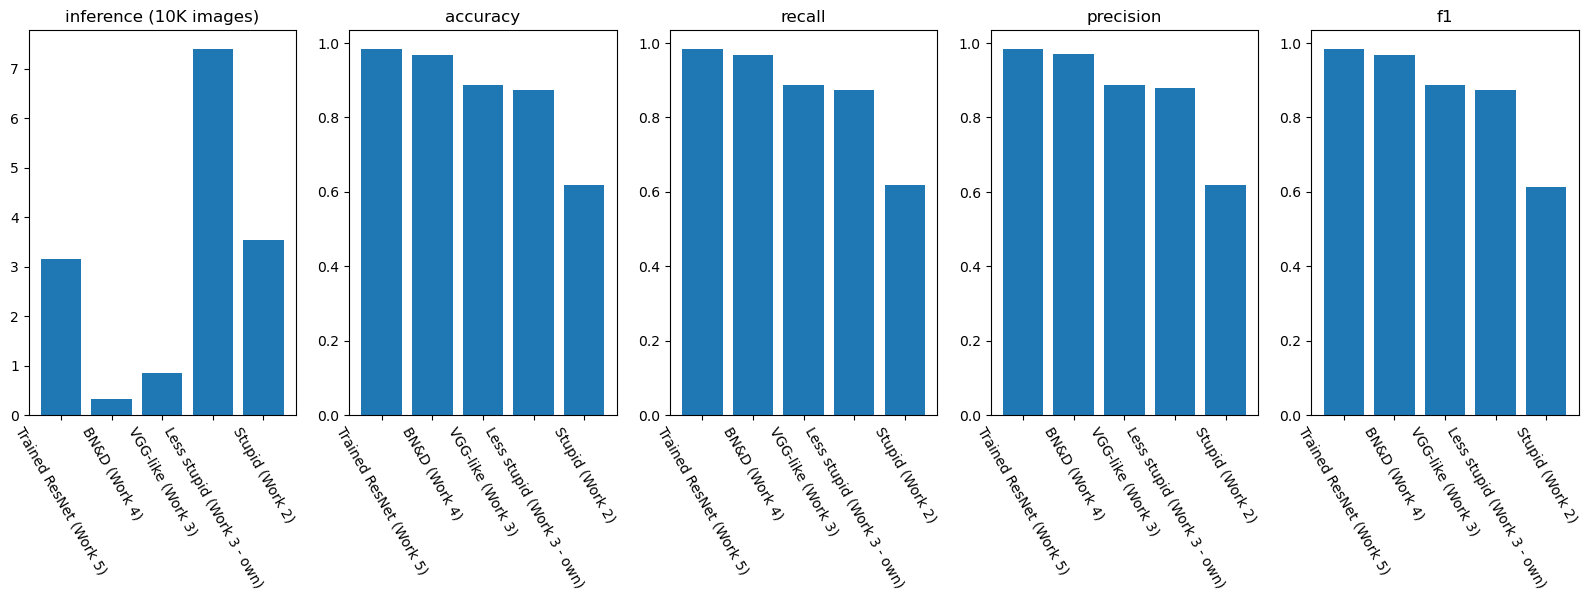

In [23]:
names = [name for name in out_df.index]
metrics = [name for name in out_df.columns]
plt.figure(figsize=(20, 5))

for i, metric in enumerate(metrics):
    values = out_df[metric].tolist()
    plt.subplot(1, 5, i+1)
    plt.xticks(rotation=-60)
    plt.bar(names, values)
    plt.title(metric)
plt.show()

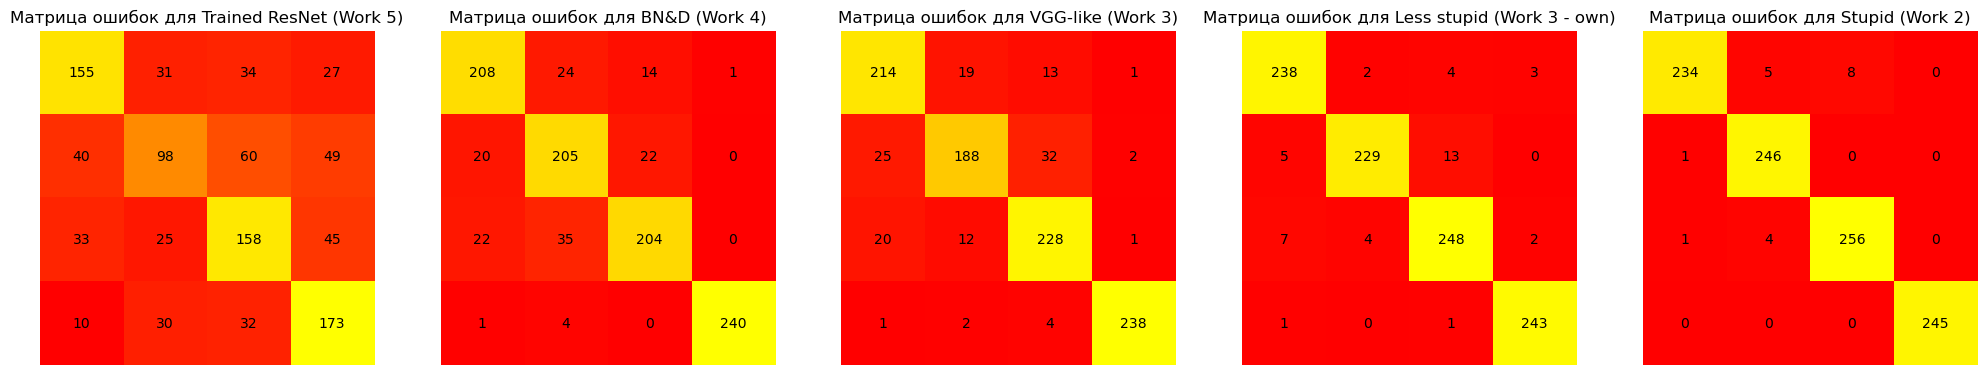

In [97]:
plt.figure(figsize=(25, 5))

for i, (heatmap, name) in enumerate(zip(cm, names)):
    plt.subplot(1, 5, i+1)
    plt.imshow(heatmap, cmap='autumn')
    plt.axis("off")
    plt.title(f"Матрица ошибок для {name}")
    for i in range(4): 
        for j in range(4): 
            plt.annotate(str(heatmap[i][j]), xy=(j, i), 
                         ha='center', va='center', color='black') 
plt.show()